In [3]:
import numpy as np
xs = []

In [4]:
class Mul():
    
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        result = x * y
        return result
    
    def backward(self, dresult):
        #f = xy 에서 dx = y, dy = x
        dx = dresult * self.y
        dy = dresult * self.x
        return dx, dy

In [5]:
class Add():
    
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        result = x + y
        return result
    
    def backward(self, dresult):
        #f = x + y 에서 dx = 1, dy = 1
        dx = dresult
        dy = dresult
        return dx, dy

In [6]:
a, b, c = -1, 3, 4
x = Add()
y = Add()
f = Mul()

In [7]:
x_result = x.forward(a, b)
y_result = y.forward(b, c)

print(x_result)
print(y_result)
print(f.forward(x_result, y_result))

2
7
14


In [8]:
dresult = 1
dx_mul, dy_mul = f.backward(dresult)

da_add, db_add_x = x.backward(dx_mul)
db_add_y, dc_add = y.backward(dy_mul)

print(dx_mul, dy_mul)
print(da_add)
print(db_add_x + db_add_y)
print(dc_add)

7 2
7
9
2


In [9]:
#활성화 함수에서의 Backpropagation
class Sigmoid():
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        xs.append(x[0])
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self, dout):
        #f = 1 / (1 + e^-x) 일 때 df = f(1-f)
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [10]:
#ReLU
class ReLU():
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.mask = (x < 0)
        self.out = x.copy()
        self.out[x<0] = 0
        return self.out
            
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [11]:
## 행렬 연산에서의 역전파

In [12]:
# 순전파
X = np.random.rand(2)
W = np.random.rand(2, 3)
B = np.random.rand(3)

print(X.shape, W.shape, B.shape)

(2,) (2, 3) (3,)


In [13]:
Y = np.dot(X, W) + B
print(Y.shape)

(3,)


In [14]:
#역전파
dL_dY = np.random.randn(3)
dL_dX = np.dot(dL_dY, W.T)
dL_dW = np.dot(X.reshape(-1, 1), dL_dY.reshape(1, -1))
dL_dB = dL_dY

print("dL_dY\n{}".format(dL_dY))
print("dL_dX\n{}".format(dL_dX))
print("dL_dW\n{}".format(dL_dW))
print("dL_dB\n{}".format(dL_dB))


dL_dY
[-1.08127732  0.53164171  0.84058935]
dL_dX
[0.29329911 0.71755538]
dL_dW
[[-0.95625992  0.47017324  0.74340032]
 [-0.81852747  0.40245304  0.63632655]]
dL_dB
[-1.08127732  0.53164171  0.84058935]


In [15]:
class Layer():
    def __init__(self):
        self.W = np.random.randn(3, 2)
        self.b = np.random.randn(2)
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [16]:
np.random.seed(111)

layer = Layer()

In [17]:
X = np.random.rand(2, 3)
Y = layer.forward(X)
print(X)

[[0.23868214 0.33765619 0.99071246]
 [0.23772645 0.08119266 0.66960024]]


In [18]:
dout = np.random.rand(2, 2)
dout_dx = layer.backward(dout)

print(dout_dx)

[[-0.59898814  0.83225859 -0.61525238]
 [-0.48312871  0.65565961 -0.42154775]]


In [19]:
##MNIST 분류
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from collections import OrderedDict

In [20]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_classes = 10

In [21]:
#데이터 전처리
X_train, X_test = X_train.reshape(-1, 28 * 28).astype(np.float32), X_test.reshape(-1, 28 * 28).astype(np.float32)

X_train /= .255
X_test /= .255

y_train = np.eye(num_classes)[y_train]

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000,)


In [23]:
#Hyper Parameters
epochs = 1000
learning_rate = 1e-3
batch_size = 100
train_size = X_train.shape[0]

In [24]:
#Util Functions
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def mean_squared_error(pred_y, true_y):
    return 0.5 * np.sum((pred_y - true_y) ** 2)

def cross_entropy_error(pred_y, true_y):
    if pred_y.ndim == 1:
        true_y = true_y.reshape(1, true_y.size)
        pred_y = pred_y.reshape(1, pred_y.size)
        
    if pred_y.size == true_y.size:
        true_y = true_y.argmax(axis=1)
        
    batch_size = pred_y.shape[0]
    return -np.sum(np.log(pred_y[np.arange(batch_size), true_y] + 1e-7)) / batch_size

def softmax_loss(X, true_y):
    pred_y = softmax(X)
    return cross_entropy_error(pred_y, true_y)

In [25]:
class Layer():
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.origin_x_shape = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.origin_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.origin_x_shape)
        return dx

In [26]:
class Softmax():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
            
        return dx

In [39]:
class MyModel():
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self. hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}
        
        self.__init_weights(activation)
        
        activation_layer = {'sigmoid': Sigmoid, 'relu': ReLU}
        self.layers = OrderedDict()
        
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
        idx = self.hidden_layer_num + 1
        self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])
        
        self.last_layer = Softmax()
        
    def __init_weights(self, activation):
        weight_std = None
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        
        for idx in range(1, len(all_size_list)):
            if activation.lower() == 'relu':
                weight_std = np.sqrt(2.0 / self.input_size)
            elif activation.lower() == 'sigmoid':
                weight_std = 2.0 * np.sqrt(2.0 / (all_size_list[idx - 1] + all_size_list[idx]))
            
            self.params['W' + str(idx)] = weight_std * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.random.randn(all_size_list[idx])
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x , true_y):
        pred_y = self.predict(x)
        return self.last_layer.forward(pred_y, true_y)
    
    def accuracy(self, x, true_y):
        pred_y = self.predict(x)
        pred_y = np.argmax(pred_y, axis=1)
        
        if true_y.ndim != 1:
            true_y = np.argmax(true_y, axis=1)
            
        accuracy = np.sum(pred_y == true_y) / float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Layer' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Layer' + str(idx)].db
            
        return grads
            
        

In [33]:
#모델 생성 및 학습
model = MyModel(28 * 28, [100, 64, 32], 10, activation='relu')

In [34]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [35]:
for epoch in range(epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = model.gradient(x_batch, y_batch)
    
    for key in model.params.keys():
        model.params[key] -= learning_rate * grad[key]
        
    loss = model.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    if epoch % 50 == 0:
        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("Epoch: {}, Train Acc: {:.4f}, Test Acc: {:.4f}".format(epoch + 1, train_acc, test_acc))

Epoch: 1, Train Acc: 0.1621, Test Acc: 0.1634
Epoch: 51, Train Acc: 0.5871, Test Acc: 0.5916
Epoch: 101, Train Acc: 0.6942, Test Acc: 0.6945
Epoch: 151, Train Acc: 0.7302, Test Acc: 0.7286
Epoch: 201, Train Acc: 0.7646, Test Acc: 0.7625
Epoch: 251, Train Acc: 0.7814, Test Acc: 0.7819
Epoch: 301, Train Acc: 0.8047, Test Acc: 0.8046
Epoch: 351, Train Acc: 0.8123, Test Acc: 0.8102
Epoch: 401, Train Acc: 0.8188, Test Acc: 0.8168
Epoch: 451, Train Acc: 0.8321, Test Acc: 0.8305
Epoch: 501, Train Acc: 0.8391, Test Acc: 0.8376
Epoch: 551, Train Acc: 0.8465, Test Acc: 0.8418
Epoch: 601, Train Acc: 0.8465, Test Acc: 0.8413
Epoch: 651, Train Acc: 0.8572, Test Acc: 0.8539
Epoch: 701, Train Acc: 0.8594, Test Acc: 0.8544
Epoch: 751, Train Acc: 0.8659, Test Acc: 0.8599
Epoch: 801, Train Acc: 0.8727, Test Acc: 0.8673
Epoch: 851, Train Acc: 0.8720, Test Acc: 0.8677
Epoch: 901, Train Acc: 0.8747, Test Acc: 0.8691
Epoch: 951, Train Acc: 0.8786, Test Acc: 0.8748
Epoch: 1001, Train Acc: 0.8842, Test Acc: 0

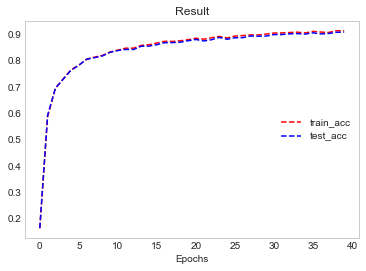

In [36]:
plt.plot(np.arange(epochs//50), train_acc_list, 'r--', label='train_acc')
plt.plot(np.arange(epochs//50), test_acc_list, 'b--', label='test_acc')

plt.title('Result')
plt.xlabel('Epochs')
plt.legend(loc=5)
plt.grid()
plt.show()

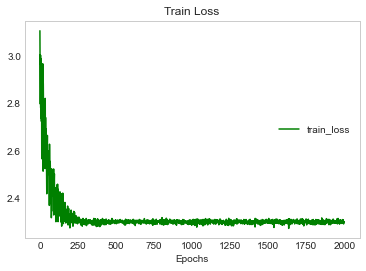

In [72]:
plt.plot(np.arange(epochs), train_loss_list, 'green', label='train_loss')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend(loc=5)
plt.grid()
plt.show()

In [43]:
#Hyper Parameters
epochs = 30000
learning_rate = 1e-2
batch_size = 10
train_size = X_train.shape[0]
#모델 생성 및 학습
model = MyModel(28 * 28, [100, 64, 32], 10, activation='sigmoid')
train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = model.gradient(x_batch, y_batch)
    
    for key in model.params.keys():
        model.params[key] -= learning_rate * grad[key]
        
    loss = model.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    if epoch % 50 == 0:
        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("Epoch: {}, Train Acc: {:.4f}, Test Acc: {:.4f}".format(epoch + 1, train_acc, test_acc))


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5760/3331577091.py:8: RuntimeWarning: overflow encountered in exp
  self.out = 1 / (1 + np.exp(-x))


Epoch: 1, Train Acc: 0.0974, Test Acc: 0.0982
Epoch: 51, Train Acc: 0.0975, Test Acc: 0.0989
Epoch: 101, Train Acc: 0.1119, Test Acc: 0.1109
Epoch: 151, Train Acc: 0.1789, Test Acc: 0.1792
Epoch: 201, Train Acc: 0.2615, Test Acc: 0.2591
Epoch: 251, Train Acc: 0.2849, Test Acc: 0.2870
Epoch: 301, Train Acc: 0.3025, Test Acc: 0.3072
Epoch: 351, Train Acc: 0.3067, Test Acc: 0.3094
Epoch: 401, Train Acc: 0.3938, Test Acc: 0.4042
Epoch: 451, Train Acc: 0.3993, Test Acc: 0.4075
Epoch: 501, Train Acc: 0.3939, Test Acc: 0.4073
Epoch: 551, Train Acc: 0.4217, Test Acc: 0.4285
Epoch: 601, Train Acc: 0.4337, Test Acc: 0.4444
Epoch: 651, Train Acc: 0.4220, Test Acc: 0.4277
Epoch: 701, Train Acc: 0.4356, Test Acc: 0.4464
Epoch: 751, Train Acc: 0.3990, Test Acc: 0.4137
Epoch: 801, Train Acc: 0.4509, Test Acc: 0.4673
Epoch: 851, Train Acc: 0.4409, Test Acc: 0.4585
Epoch: 901, Train Acc: 0.4374, Test Acc: 0.4544
Epoch: 951, Train Acc: 0.5150, Test Acc: 0.5262
Epoch: 1001, Train Acc: 0.4936, Test Acc: 0

Epoch: 8401, Train Acc: 0.7641, Test Acc: 0.7621
Epoch: 8451, Train Acc: 0.7672, Test Acc: 0.7720
Epoch: 8501, Train Acc: 0.7503, Test Acc: 0.7591
Epoch: 8551, Train Acc: 0.7529, Test Acc: 0.7607
Epoch: 8601, Train Acc: 0.7537, Test Acc: 0.7578
Epoch: 8651, Train Acc: 0.7643, Test Acc: 0.7697
Epoch: 8701, Train Acc: 0.7603, Test Acc: 0.7692
Epoch: 8751, Train Acc: 0.7655, Test Acc: 0.7670
Epoch: 8801, Train Acc: 0.7505, Test Acc: 0.7544
Epoch: 8851, Train Acc: 0.7510, Test Acc: 0.7549
Epoch: 8901, Train Acc: 0.7611, Test Acc: 0.7649
Epoch: 8951, Train Acc: 0.7514, Test Acc: 0.7543
Epoch: 9001, Train Acc: 0.7588, Test Acc: 0.7625
Epoch: 9051, Train Acc: 0.7557, Test Acc: 0.7612
Epoch: 9101, Train Acc: 0.7595, Test Acc: 0.7684
Epoch: 9151, Train Acc: 0.7561, Test Acc: 0.7608
Epoch: 9201, Train Acc: 0.7637, Test Acc: 0.7688
Epoch: 9251, Train Acc: 0.7687, Test Acc: 0.7730
Epoch: 9301, Train Acc: 0.7664, Test Acc: 0.7771
Epoch: 9351, Train Acc: 0.7656, Test Acc: 0.7685
Epoch: 9401, Train A

Epoch: 16651, Train Acc: 0.7345, Test Acc: 0.7284
Epoch: 16701, Train Acc: 0.7373, Test Acc: 0.7364
Epoch: 16751, Train Acc: 0.7460, Test Acc: 0.7391
Epoch: 16801, Train Acc: 0.7359, Test Acc: 0.7297
Epoch: 16851, Train Acc: 0.7395, Test Acc: 0.7357
Epoch: 16901, Train Acc: 0.7556, Test Acc: 0.7500
Epoch: 16951, Train Acc: 0.7572, Test Acc: 0.7486
Epoch: 17001, Train Acc: 0.7614, Test Acc: 0.7566
Epoch: 17051, Train Acc: 0.7558, Test Acc: 0.7563
Epoch: 17101, Train Acc: 0.7705, Test Acc: 0.7725
Epoch: 17151, Train Acc: 0.7712, Test Acc: 0.7767
Epoch: 17201, Train Acc: 0.7606, Test Acc: 0.7593
Epoch: 17251, Train Acc: 0.7675, Test Acc: 0.7722
Epoch: 17301, Train Acc: 0.7670, Test Acc: 0.7679
Epoch: 17351, Train Acc: 0.7609, Test Acc: 0.7630
Epoch: 17401, Train Acc: 0.7621, Test Acc: 0.7637
Epoch: 17451, Train Acc: 0.7591, Test Acc: 0.7633
Epoch: 17501, Train Acc: 0.7437, Test Acc: 0.7394
Epoch: 17551, Train Acc: 0.7508, Test Acc: 0.7543
Epoch: 17601, Train Acc: 0.7582, Test Acc: 0.7604


MemoryError: Unable to allocate 45.8 MiB for an array with shape (60000, 100) and data type float64

In [ ]:
        
plt.plot(np.arange(epochs//50), train_acc_list, 'r--', label='train_acc')
plt.plot(np.arange(epochs//50), test_acc_list, 'b--', label='test_acc')

plt.title('Result')
plt.xlabel('Epochs')
plt.legend(loc=5)
plt.grid()
plt.show()

plt.plot(np.arange(epochs), train_loss_list, 'green', label='train_loss')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend(loc=5)
plt.grid()
plt.show()